### GutSLAM: Photometric Pose and Deformation Estimation 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import cv2
import os

In [5]:
''' Feature Detection and Matching ORB Desc'''
def detect_compute(images):
    ''' Takes a list of images and returns keypoints and descriptors for each image in the list'''
    orb=cv2.ORB_create()
    keypoints=[]
    descriptors=[]

    for image in images:
        gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoint, descriptor=orb.detectAndCompute(gray, None)

        keypoints.append(keypoint)
        descriptors.append(descriptor)

    return keypoints, descriptors


def match_keypoint(descriptors):
    ''' Takes a list of descriptors and returns a list of matches between consecutive images'''
    matches=[]
    bf=cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    #match keypoints between consecutive images
    for i in range(len(descriptors)-1):
        matches.append(bf.match(descriptors[i], descriptors[i+1]))
    
    return matches

def create_corres_matrix(matches,num_images, num_corres):
    ''' Takes in matches, num_images in batch and number of correspondences and returns a correspondence matrix'''

    corres_mat=np.zeros((num_corres, num_images), dtype=int)

    for i, match in enumerate(matches):
        #sort matches based on distance
        match=sorted(match, key=lambda x:x.distance)

        #get the first num_corres matches
        match=match[:num_corres]

        #extract indices of the matches
        indices=[mat.queryIdx for mat in match]

        #populate the correspondence matrix
        corres_mat[:,i]=indices

    return corres_mat

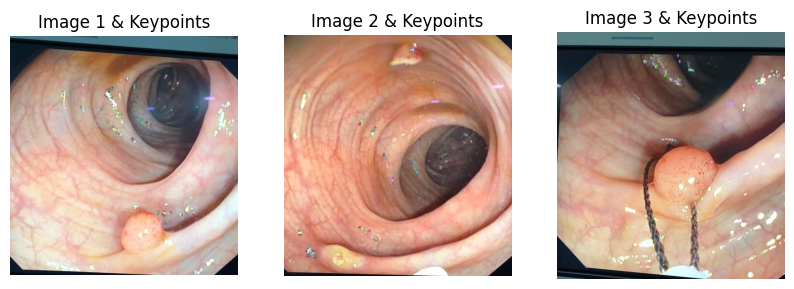

In [16]:
def read_images_from_folder(folder_path):
    ''' Reads images from a folder and returns a list of images'''
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images

def display_images_with_keypoints(images, keypoints):
    ''' Displays images with keypoints in a single row'''
    num_images = len(images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))  

    for i in range(num_images):
        img_with_keypoints = cv2.drawKeypoints(images[i], keypoints[i], None)
        axes[i].imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Image {i+1} & Keypoints')
        axes[i].axis('off')

    plt.show()

if __name__ == "__main__":
    folder_path = 'gut_images'  # Replace with the path to your image folder
    images = read_images_from_folder(folder_path)

    keypoints, descriptors = detect_compute(images)
    matches = match_keypoint(descriptors)
    num_images = len(images)
    num_corres = 10  # You can adjust this based on your requirements
    corres_mat = create_corres_matrix(matches, num_images, num_corres)

    display_images_with_keypoints(images, keypoints)

In [18]:
print(keypoints[0][0].pt)
print(corres_mat)

(641.0, 411.0)
[[348 309   0]
 [460 419   0]
 [436 427   0]
 [434 173   0]
 [ 97 322   0]
 [310 364   0]
 [409 429   0]
 [ 59 438   0]
 [165  89   0]
 [ 34 388   0]]


In [ ]:
# import numpy as np
# from cvxpy import Variable, Minimize, Problem, norm

# def formulate_nrsfm_sdp_cylinder(P, Q):
#     """
#     Formulate Non-Rigid Structure from Motion as a Semi-Definite Programming problem
#     with the assumption of a cylindrical structure.

#     Parameters:
#     - P: List of projection matrices for each image
#     - Q: List of corresponding 2D points in each image

#     Returns:
#     - SDP problem and variables
#     """
#     num_images = len(P)
#     num_points = Q[0].shape[0]

#     # Variables
#     X = Variable((num_points, 3))
#     C = Variable((num_points, num_points), symmetric=True)

#     # Cost function
#     cost = 0
#     for i in range(num_images):
#         cost += norm(Q[i] - P[i][:, :3] @ X.T - P[i][:, 3].reshape((-1, 1)).T)

#     # Additional constraint for cylindrical structure
#     cylindrical_constraint = norm(X[:, :2], axis=1) - X[:, 2]

#     # Objective
#     objective = Minimize(cost + 0.1 * sum(cylindrical_constraint))  # Adjust the weight for the cylinder constraint

#     # Constraints
#     constraints = [C >> 0, X.T @ C @ X == np.eye(3)]

#     # Create problem
#     problem = Problem(objective, constraints)

#     return problem, X

# # Generate synthetic data assuming a cylindrical structure
# np.random.seed(42)
# num_images = 3
# num_points = 5

# # Assume cylindrical structure
# theta = np.linspace(0, 2 * np.pi, num_points)
# radius = 1.0
# X_true = np.column_stack((radius * np.cos(theta), radius * np.sin(theta), np.zeros(num_points))).T

# # Assume simple projection matrices
# P_true = [np.eye(3, 4) for _ in range(num_images)]

# # Project the 3D points into 2D
# Q = [np.dot(P_true[i], np.hstack((X_true, np.ones((num_points, 1)))).T)[:2, :].T for i in range(num_images)]
# Q += 0.01 * np.random.randn(num_images, num_points, 2)  # Add noise to 2D points

# # Formulate and solve NRSfM as SDP with cylindrical constraint
# problem, X_var = formulate_nrsfm_sdp_cylinder(P_true, Q)
# problem.solve()

# # Extract optimized 3D points
# X_optimized = X_var.value

# print("True 3D points (cylindrical structure):")
# print(X_true)

# print("\nOptimized 3D points:")
# print(X_optimized)

# print("\nOptimization status:", problem.status)
# print("Optimal value (reprojection error):", problem.value)
